In [3]:
import numpy as np
from itertools import product
from skimage import draw, transform

def circle(size, val=None, r_shrink=0):
    circle = np.zeros([size[0]+1, size[1]+1])
    rr, cc = draw.circle_perimeter(
        size[0]//2, size[1]//2,
        radius=size[0]//2 - r_shrink,
        shape=[size[0]+1, size[1]+1],
    )
    if val is None:
        circle[rr, cc] = np.random.uniform(size=circle.shape)[rr, cc]
    else:
        circle[rr, cc] = val
    circle = transform.resize(circle, size, order=0)
    return circle

def show_kernel(kernel, label=True, digits=None, text_size=28):
    # Format kernel
    kernel = np.array(kernel)
    if digits is not None:
        kernel = kernel.round(digits)

    # Plot kernel
    cmap = plt.get_cmap('Blues_r')
    plt.imshow(kernel, cmap=cmap)
    rows, cols = kernel.shape
    thresh = (kernel.max()+kernel.min())/2
    # Optionally, add value labels
    if label:
        for i, j in product(range(rows), range(cols)):
            val = kernel[i, j]
            color = cmap(0) if val > thresh else cmap(255)
            plt.text(j, i, val, 
                     color=color, size=text_size,
                     horizontalalignment='center', verticalalignment='center')
    plt.xticks([])
    plt.yticks([])

def show_extraction(image,
                    kernel,
                    conv_stride=1,
                    conv_padding='valid',
                    activation='relu',
                    pool_size=2,
                    pool_stride=2,
                    pool_padding='same',
                    figsize=(10, 10),
                    subplot_shape=(2, 2),
                    ops=['Input', 'Filter', 'Detect', 'Condense'],
                    gamma=1.0):
    # Create Layers
    model = tf.keras.Sequential([
                    tf.keras.layers.Conv2D(
                        filters=1,
                        kernel_size=kernel.shape,
                        strides=conv_stride,
                        padding=conv_padding,
                        use_bias=False,
                        input_shape=image.shape,
                    ),
                    tf.keras.layers.Activation(activation),
                    tf.keras.layers.MaxPool2D(
                        pool_size=pool_size,
                        strides=pool_stride,
                        padding=pool_padding,
                    ),
                   ])

    layer_filter, layer_detect, layer_condense = model.layers
    kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
    layer_filter.set_weights([kernel])

    # Format for TF
    image = tf.expand_dims(image, axis=0)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) 
    
    # Extract Feature
    image_filter = layer_filter(image)
    image_detect = layer_detect(image_filter)
    image_condense = layer_condense(image_detect)
    
    images = {}
    if 'Input' in ops:
        images.update({'Input': (image, 1.0)})
    if 'Filter' in ops:
        images.update({'Filter': (image_filter, 1.0)})
    if 'Detect' in ops:
        images.update({'Detect': (image_detect, gamma)})
    if 'Condense' in ops:
        images.update({'Condense': (image_condense, gamma)})
    
    # Plot
    plt.figure(figsize=figsize)
    for i, title in enumerate(ops):
        image, gamma = images[title]
        plt.subplot(*subplot_shape, i+1)
        plt.imshow(tf.image.adjust_gamma(tf.squeeze(image), gamma))
        plt.axis('off')
        plt.title(title)

###  Parameters  
`strides` : 한번에 얼만큼 window를 움직일지를 결정  
`padding` : image edge들에 사용

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu'),
    layers.MaxPool2D(pool_size=2,
                    strides=1,
                    padding='same')
])

##### Padding
1. padding = `valid` : convolution windo가 input 안에 그대로 있음. 
2. padding = `same` : pad the input with 0's around its borders
  
- VGG 모델은 2번을 사용.  
- 요즘에는 둘다 같이 사용하는 경우가 많다.

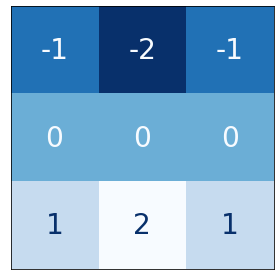

In [4]:
# Example
# create a image and kernel
import tensorflow as tf
import matplotlib.pyplot as plt

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
      titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

image = circle([64, 64], val=1.0, r_shrink=3)
image = tf.reshape(image, [*image.shape, 1])

kernel = tf.constant([
    [-1,-2,-1],
    [0,0,0],
    [1,2,1]
])
show_kernel(kernel)

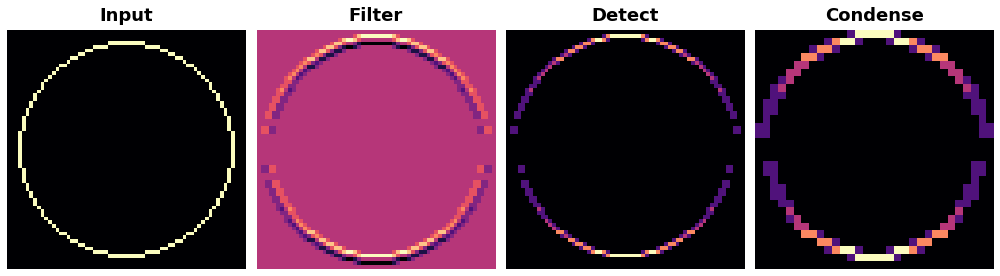

In [8]:
show_extraction(image, kernel, conv_stride=1, pool_size=2, pool_stride=2,
               subplot_shape=(1,4),
               figsize=(14, 6))

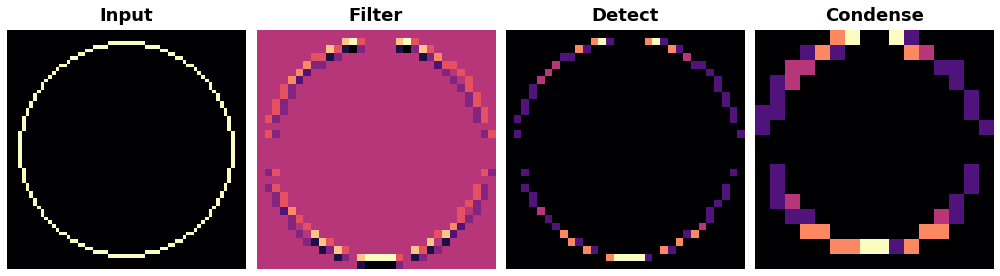

In [9]:
#too coarse case
show_extraction(image, kernel, conv_stride=2, pool_size=2, pool_stride=2,
               subplot_shape=(1,4),
               figsize=(14, 6))